In [2]:
import numpy as np
import matplotlib.pyplot as plt
from crossover_manifold import search_w
from scipy.special import comb
import warnings

In [3]:
def PalHuseSelector(eigenvalues, min_size=5):
    """ Select eigenvalues in the middle third of the spectrum,
         as done by Pal and Huse in 10.1103/PhysRevB.82.174411 """

    idx = np.arange(eigenvalues.size)
    l = eigenvalues.size - 1
    start, end = l/3, 2*l/3
    if end - start + 1 < min_size:
        warnings.warn(f"Spectrum is too small for selector ({l+1}/3 < {min_size} (min_size)). Returning middle {min_size} elements instead.")
    start, end = min(start, (l - min_size)/2), max(end, (l + min_size)/2)
    mask = (idx > start) & (idx < end)
    return mask

def spacings(results):
	s = np.diff(results, axis=1)
	s = s / np.mean(s, axis=1).reshape(-1, 1)
	return s

def eigenvalues(results):
	return results.flatten()

def d2correlations(results):
	""" Calculate the correlations between adjacent spacings
		as in Oganesyan and Huse
		https://doi.org/10.1103/PhysRevB.75.155111 """
	delta = spacings(results)
	dn, dnm1 = delta[:, :-1], delta[:, 1:]
	r = np.minimum(dn, dnm1) / np.maximum(dn, dnm1)
	return r

In [4]:
from fastparticles.matrixensembles import BosonChainSampler, MatrixStats, PalHuseSelector

K = 0.5

def my_simulator(W, n, e):
	sampler = BosonChainSampler(n, W, 1, K, e, 100)
	matrixstats = MatrixStats(sampler)
	matrixstats.collect(n_points=50000)
	return matrixstats.s(PalHuseSelector).flatten()
simulator = my_simulator

In [5]:
def computationally_intractable(n, e, size_cutoff=5000):
	ncomb = comb(n+e-1, e, exact=True)
	if ncomb > size_cutoff:
		return True
	return False

## Single-particle localisation length as a function of W
Single-particle systems are simulated with different disorder in order to find the value of critical disorder $W_{crit}$ for each $n$. This determines whether the system is Anderson localized.

In [61]:
import pickle
filename = "results/loc_length_W_ravg.pickle"
try:
	with open(filename, "rb") as f:
		results = pickle.load(f)
except:
	results = {}
K=0
n_e_list = [[n, e] for n in range(15, 100) for e in range(1, 2) if not computationally_intractable(n, e)]
for n, e in n_e_list:
	if (n, e) in results:
		continue
	distribution_f = lambda W: d2correlations(simulator(W, n, e, K, n_points=10000)).flatten()
	print(f"Searching for n={n}, e={e}...", end="")
	Wcrit = search_w(distribution_f, (0.0, 50), rtol=0.03, tol=0.5, target=0.45)
	results[(n, e)] = Wcrit
	print(f" done. Found Wcrit at {Wcrit}")
	with open(filename, "wb") as f:
		pickle.dump(results, f)
	plt.pause(0.01)

In [ ]:
import numpy as np
from scipy.optimize import curve_fit

def plot_results(results, ax, e_num=1):
	markers = ['o', 's', 'D', 'v', '^', 'p', '*', 'h', 'H', 'x']
	x, y = [], []
	for (n, e), Wcrit in results.items():
		x.append(n)
		y.append(Wcrit)

	def fit_function(x, a, b):
		return a * 1/(x**b)

	x = np.array(x)
	y = np.array(y)

	popt, pcov = curve_fit(fit_function, x, y, bounds=([0, 0.5],[100, 1.1]))

	# Generate points for the fitted curve
	x_fit = np.linspace(min(x), max(x), 100)
	y_fit = fit_function(x_fit, *popt)

	# Plot the original points and the fitted curve
	ax.scatter(x, y, marker=markers[e_num], label=r'$W_{crit}$' + f", {e_num} particles", s=6)
	ax.plot(x_fit, y_fit, label='Fitted Curve' + f", {e_num} particles")
	ax.text(0.05, 1 - e_num*0.05, f'$f(n)=a/n^b$ a={popt[0]:.2f}, b={popt[1]:.2f}', transform=ax.transAxes)

	ax.set_xlabel('n')
	ax.set_ylabel('Wcrit')
	ax.set_ylim(0, 15)
	ax.set_xlim(0, 100)
	ax.legend()
	ax.grid()

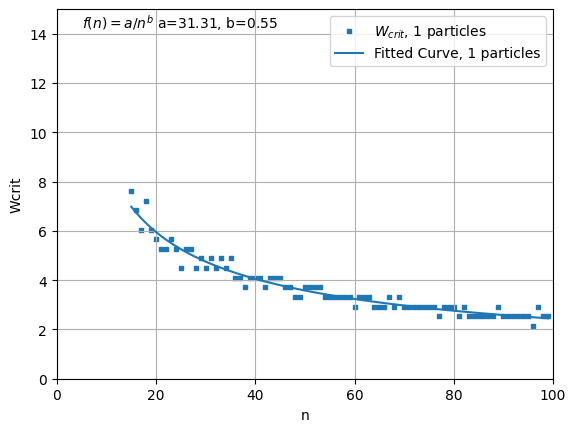

In [62]:
fig, ax = plt.subplots(1,1)
plot_results(results, ax)
plt.savefig("loc_length_W.png", dpi=300)
plt.savefig("loc_length_W.pdf")
plt.show()


## Two-particle localisation length as a function of W, with fixed K

In [ ]:
import pickle
filename = "results/loc_length_W_ravg_e2.pickle"
try:
	with open(filename, "rb") as f:
		results = pickle.load(f)
except:
	results = {}
K=2
n_e_list = [[n, e] for n in range(5, 100) for e in range(2, 3) if not computationally_intractable(n, e)]
for n, e in n_e_list:
	if (n, e) in results:
		continue
	distribution_f = lambda W: d2correlations(simulator(W, n, e, K, n_points=10000)).flatten()
	print(f"Searching for n={n}, e={e}...")
	Wcrit = search_w(distribution_f, (0.0, 50), rtol=0.03, tol=0.1, target=0.45)
	results[(n, e)] = Wcrit
	print("\r\r",end="")
	print(f" done. Found Wcrit at {Wcrit}")
	with open(filename, "wb") as f:
		pickle.dump(results, f)
	plt.pause(0.01)

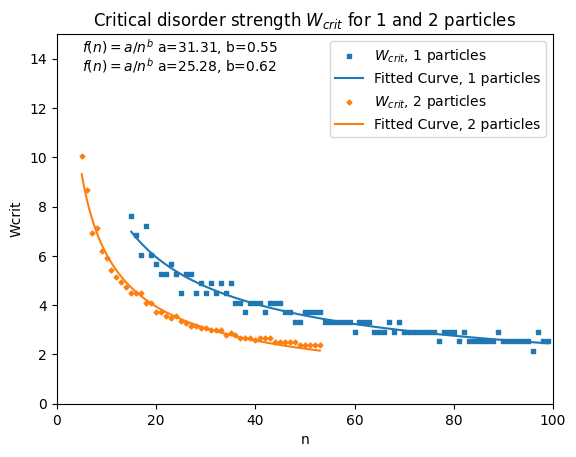

In [60]:
fig, ax = plt.subplots(1, 1)

filename = "results/loc_length_W_ravg.pickle"
with open(filename, "rb") as f:
	results = pickle.load(f)
plot_results(results, ax, e_num=1)
filename = "results/loc_length_W_ravg_e2.pickle"
with open(filename, "rb") as f:
	results = pickle.load(f)
plot_results(results, ax, e_num=2)
ax.set_title(r"Critical disorder strength $W_{crit}$ for 1 and 2 particles")
plt.savefig("loc_length_W_e.png", dpi=300)
plt.savefig("loc_length_W_e.pdf")

## Crossover manifold
A $n=10$ system with 2 particles is simulated varying the value of interaction strength $K$. The disorder strength is varied to find the critical $W_{crit}$ that makes the system many-body localized.

In [70]:
import pickle
filename = "results/Wcrit_e2.pickle"
try:
	with open(filename, "rb") as f:
		results = pickle.load(f)
except:
	results = {}
n = 10
e=2
K_list = np.around(np.linspace(0, 5, 100), 2)
for K in K_list:
	if K in results.keys():
		continue
	distribution_f = lambda W: d2correlations(simulator(W, n, e, K, n_points=50000)).flatten()
	print(f"Searching for e={e}, K={K:.2f}...")
	Wcrit = search_w(distribution_f, (0.0, 20), rtol=0.05, tol=0.2, target=0.45)
	results[K] = Wcrit
	print("\r\r"+f"e={e}, K={K:.2f} done. Found Wcrit at {Wcrit:.2f}")
	with open(filename, "wb") as f:
		pickle.dump(results, f)

Searching for e=2, K=0.00...
e=2, K=0.00 done. Found Wcrit at 0.39
Searching for e=2, K=0.05...
e=2, K=0.05 done. Found Wcrit at 0.86
Searching for e=2, K=0.10...
e=2, K=0.10 done. Found Wcrit at 1.80
Searching for e=2, K=0.15...
e=2, K=0.15 done. Found Wcrit at 2.73
Searching for e=2, K=0.20...
e=2, K=0.20 done. Found Wcrit at 3.36
Searching for e=2, K=0.25...
e=2, K=0.25 done. Found Wcrit at 3.83
Searching for e=2, K=0.30...
e=2, K=0.30 done. Found Wcrit at 4.30
Searching for e=2, K=0.35...
e=2, K=0.35 done. Found Wcrit at 4.77
Searching for e=2, K=0.40...
e=2, K=0.40 done. Found Wcrit at 4.77
Searching for e=2, K=0.45...
e=2, K=0.45 done. Found Wcrit at 5.23
Searching for e=2, K=0.51...
e=2, K=0.51 done. Found Wcrit at 5.23
Searching for e=2, K=0.56...
e=2, K=0.56 done. Found Wcrit at 5.23
Searching for e=2, K=0.61...
e=2, K=0.61 done. Found Wcrit at 5.55
Searching for e=2, K=0.66...
e=2, K=0.66 done. Found Wcrit at 5.55
Searching for e=2, K=0.71...
e=2, K=0.71 done. Found Wcrit at 

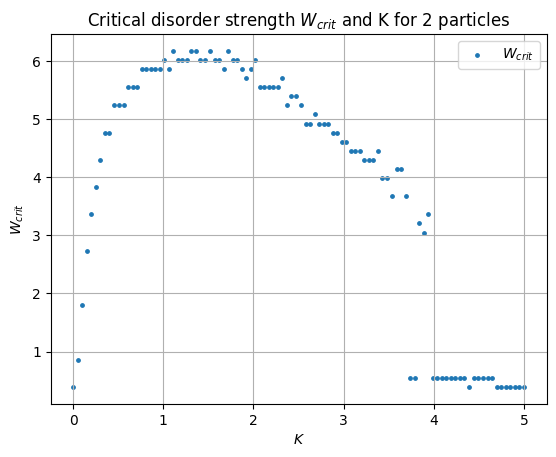

In [75]:
fig, ax = plt.subplots(1, 1)

filename = "results/Wcrit_e2.pickle"
with open(filename, "rb") as f:
	results = pickle.load(f)
	
x, y = [], []
for K, W in results.items():
	x.append(K)
	y.append(W)

def fit_function(x, a, b):
	return a * 1/(x**b)

x = np.array(x)
y = np.array(y)

# popt, pcov = curve_fit(fit_function, x, y, bounds=([0, 0.5],[100, 1.1]))

# Generate points for the fitted curve
# x_fit = np.linspace(min(x), max(x), 100)
# y_fit = fit_function(x_fit, *popt)

# Plot the original points and the fitted curve
ax.scatter(x, y, label=r'$W_{crit}$', s=6)
# ax.plot(x_fit, y_fit, label='Fitted Curve')
# ax.text(0.05, 1 - 0.05, f'$f(n)=a/n^b$ a={popt[0]:.2f}, b={popt[1]:.2f}', transform=ax.transAxes)

ax.set_xlabel('$K$')
ax.set_ylabel(r'$W_{crit}$')
ax.legend()
ax.grid()

ax.set_title(r"Critical disorder strength $W_{crit}$ and K for 2 particles")
plt.savefig("results/loc_length_W_K.png", dpi=300)
plt.savefig("results/loc_length_W_K.pdf")

0.42469714391649865


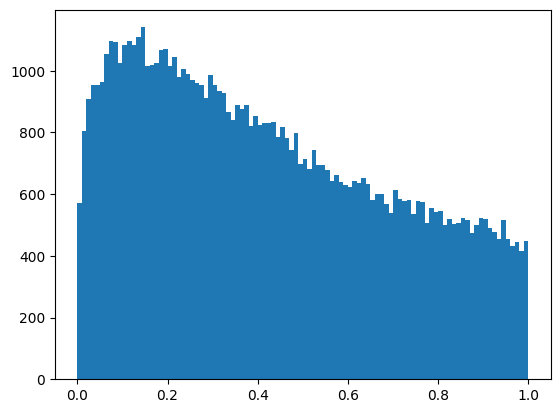

In [31]:
e = simulator(9, 10, 2, K=2, n_points=50000)
gapc = d2correlations(e).flatten()
_ = plt.hist(gapc, bins=100)
print(np.mean(gapc))

## Particles e and disorder W dependence of $r(W,L)$

In [ ]:
from collections import defaultdict
from tqdm.notebook import tqdm

W_l = list(range(2,13))
e_l = list(range(2,5))
n=10
results = dict()
for e in tqdm(e_l, desc="Progress e"):
	r_l, err_l = [], []
	for W in tqdm(W_l, desc="Progress W", leave=False):
		eigs = simulator(W, n, e, K=1, n_points=50000)
		r = d2correlations(eigs).flatten().mean()
		er = d2correlations(eigs).flatten().std() / np.sqrt(len(eigs))
		r_l.append(r)
		err_l.append(er)
	results[e] = (r_l, err_l)

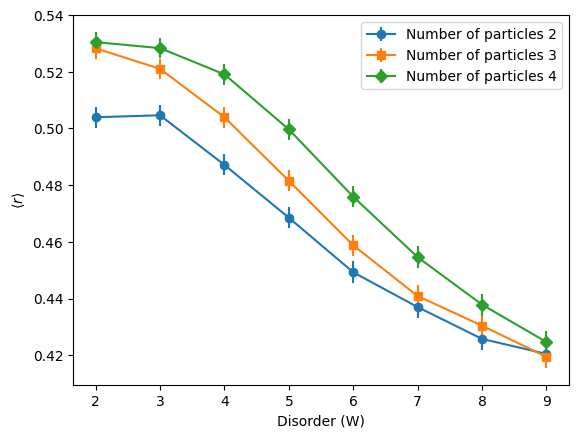

In [26]:
fig, ax = plt.subplots()
markers = ['o', 's', 'D', 'v', '^', 'p', '*', 'h', 'H', 'x']
for i, (r_l, err_l) in enumerate(results.values()):
	e = e_l[i]
	ax.errorbar(W_l, r_l, yerr=err_l, marker=markers[i], label=f"Number of particles {e}", linestyle='-')

ax.set_xlabel('Disorder (W)')
ax.set_ylabel(r'$\langle r \rangle$')
ax.legend()
